<a href="https://colab.research.google.com/github/dahui-y/Awesome-Diffusion-Models-in-Medical-Imaging/blob/main/DeePiCt_predict3d.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This Colab notebook can be used to create predictions with already trained 3D models for ribosome, membrane, microtubule and FAS prediction. The tomogram that you want to use for prediction should be available somewhere online, for example on Drive. The initial step of the spectrum matching filter is not included in the notebook, and you should execute it beforehand. For more details about the model, follow the instructions available on the [DeePiCt Github repository](https://github.com/ZauggGroup/DeePiCt/blob/main/README.md).  

## Instructions:
* This notebook includes 4 steps to segment the tomogram and optional step 5 for visualization of the result.
* Make sure that the tomogram with applied filter is available on an online share, example Google Drive.
* Run the cells in the order that they are displayed. To run a cell, you need to click the play button on the left corner of the cell.
* Some cells contain parameters that need to be defined, so make sure you enter all the required information correctly before running the particular cell. You have to run the cell, so that the parameter value is saved.




# Configurations
___

### Make sure you have GPU access enabled by going to Runtime -> Change Runtime Type -> Hardware accelerator and selecting GPU

## Step 1. Installations
___

In [1]:
#@markdown ## 1.1. Run this cell to connect your Google Drive to colab

#@markdown * Click on the URL.

#@markdown * Sign in your Google Account.

#@markdown You will either have to:
#@markdown * copy the authorisation code and enter it into box below OR

#@markdown * in the new google colab, you can just click "Allow" and it should connect.

#@markdown * Click on "Folder" icon on the Left, press the refresh button. Your Google Drive folder should now be available here as "gdrive".

# mount user's Google Drive to Google Colab.
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
#@markdown ## 1.2. Run this cell to install necessary packages

#@markdown The code in this cell:
#@markdown * Gets the git repository of DeePiCt

!git clone https://github.com/ZauggGroup/DeePiCt.git

#@markdown * Installs required packages

!pip install mrcfile
!pip install tensorboardX

Cloning into 'DeePiCt'...
remote: Enumerating objects: 1479, done.
remote: Counting objects: 100% (106/106), done.
remote: Compressing objects: 100% (54/54), done.
remote: Total 1479 (delta 68), reused 80 (delta 52), pack-reused 1373 (from 1)
Receiving objects: 100% (1479/1479), 7.38 MiB | 28.51 MiB/s, done.
Resolving deltas: 100% (984/984), done.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.7/101.7 kB 2.3 MB/s eta 0:00:00


## Step 2. Set the data variables and config file

___

In [3]:
#@markdown ## 2.1. Choose the model based on what you want to segment. The available models are prediction for membrane, ribosome, microtubules, and FAS.

# Define the variable:
predict_type = "membrane" #@param ["ribosome","membrane", "microtubule", "FAS"]

models_weights = {"ribosome": "https://www.dropbox.com/sh/oavbtcvusi07xbh/AAB4CRl9fY4hX9ypsAhwDrNna/3d_cnn/full_vpp_ribo_model_IF4_D2_BN.pth?dl=0",
                  "membrane": "https://www.dropbox.com/sh/oavbtcvusi07xbh/AADm29QsXAHenTSTkASMcCk0a/3d_cnn/full_vpp_memb_model_IF4_D2_BN.pth?dl=0",
                  "microtubule": "https://www.dropbox.com/sh/oavbtcvusi07xbh/AAAtAV19H3ar5nE2KYecqZf3a/3d_cnn/11cents5inter6mitotic_pp.pth?dl=0",
                  "FAS": "https://www.dropbox.com/sh/oavbtcvusi07xbh/AACeAnRVDjCNy9viktZVdxiza/3d_cnn/full_vpp_fas_model_IF16_D2_BN.pth?dl=0"}

mapping = {'microtubule': 'microtubule', 'ribosome':'ribo', 'FAS':'fas', 'membrane':'mem'}
class_name = mapping[predict_type]
!wget -O model_weights.pth {models_weights[predict_type]}

--2024-10-30 07:48:52--  https://www.dropbox.com/sh/oavbtcvusi07xbh/AADm29QsXAHenTSTkASMcCk0a/3d_cnn/full_vpp_memb_model_IF4_D2_BN.pth?dl=0
Resolving www.dropbox.com (www.dropbox.com)... 162.125.3.18, 2620:100:6019:18::a27d:412
Connecting to www.dropbox.com (www.dropbox.com)|162.125.3.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://www.dropbox.com/scl/fo/5jd6tenge2fh1o7rocdaz/AEPhyq7YSBqwuf9RZXmk1Gg/3d_cnn/full_vpp_memb_model_IF4_D2_BN.pth?rlkey=mtxfllw54y8rln88p0az6tklv&dl=0 [following]
--2024-10-30 07:48:52--  https://www.dropbox.com/scl/fo/5jd6tenge2fh1o7rocdaz/AEPhyq7YSBqwuf9RZXmk1Gg/3d_cnn/full_vpp_memb_model_IF4_D2_BN.pth?rlkey=mtxfllw54y8rln88p0az6tklv&dl=0
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://ucb64c681729006392734aa0da67.dl.dropboxusercontent.com/cd/0/inline/CdaFf84_mdy-4pv5AZQLqx1Uz4PYJQGg6zvR28sGG2qmklmKL6W1JTdMVI5Dx8DRTW6Pycl-gOPfspoBWSb6tlzbB2DtUmSt5b

In [4]:
from posixpath import split
#@markdown ## 2.2. Define important variables

#@markdown ### Define the following information in the given variables:

scriptdir = '/content/DeePiCt/3d_cnn/scripts'
srcdir = '/content/DeePiCt/3d_cnn/src/'
original_config_file = '/content/DeePiCt/3d_cnn/config.yaml'
model_path = '/content/model_weights.pth'

# Define the folowing variables:

# @markdown * **ID/name for the tomogram**:
tomo_name = '15042022_32_filtered' #@param {type:"string"}

# @markdown * **Path to the tomogram .mrc file**:
tomogram_path = '/content/drive/MyDrive/15042022_32_filtered.mrc' #@param {type:"string"}

# @markdown * **Path to the mask .mrc file used for processing (if there is no mask leave it empty)**:
mask_path = '' #@param {type:"string"}

#@markdown ### You don't need to change the following variables:

# @markdown * *Path where the config .yaml file will be saved (you can leave the default option)*:
user_config_file = '/content/drive/MyDrive/DeePiCt_3d/config.yaml'  #@param {type:"string"}

# @markdown * *Path where the data .csv file will be saved (you can leave the default option)*:
user_data_file = '/content/drive/MyDrive/DeePiCt_3d/data.csv' #@param {type:"string"}

# @markdown * *Path to folder where the prediction files will be saved (you can leave the default option)*:
user_prediction_folder = '/content/drive/MyDrive/DeePiCt_3d/'  #@param {type:"string"}

# @markdown *  *Path to folder where the intermediate files will be saved (you can leave the default option)*:
user_work_folder = '/content/drive/MyDrive/work/'  #@param {type:"string"}

import os

os.makedirs(os.path.split(user_config_file)[0], exist_ok=True)
os.makedirs(os.path.split(user_data_file)[0], exist_ok=True)
os.makedirs(os.path.split(user_prediction_folder)[0], exist_ok=True)
os.makedirs(os.path.split(user_work_folder)[0], exist_ok=True)


In [5]:
#@markdown ## 2.3. Create data csv file and yaml config file
#@markdown Run this cell to create the .csv data file and .yaml config file

import csv
import yaml

header = ['tomo_name','raw_tomo','filtered_tomo', 'no_mask']

# Define the elements of this list:
data = [tomo_name, '', tomogram_path, mask_path]

with open(user_data_file, 'w', encoding='UTF8') as f:
    writer = csv.writer(f)

    # write the header
    writer.writerow(header)

    # write the data
    writer.writerow(data)

data_dictionary = dict(zip(header, data))

def read_yaml(file_path):
    with open(file_path, "r") as stream:
        data = yaml.safe_load(stream)
    return data

def save_yaml(data, file_path):
    with open(file_path, 'w') as yaml_file:
        yaml.dump(data, yaml_file, default_flow_style=False)

d = read_yaml(original_config_file)
d['dataset_table'] = user_data_file
d['output_dir'] = user_prediction_folder
d['work_dir'] = user_work_folder
d['model_path'] = f'{model_path}'
d['tomos_sets']['training_list'] = []
d['tomos_sets']['prediction_list'] = [f'{tomo_name}']
d['cross_validation']['active'] = False
d['training']['active'] = False
d['prediction']['active'] = True
d['evaluation']['particle_picking']['active'] = False
d['evaluation']['segmentation_evaluation']['active'] = False
d['training']['processing_tomo'] = 'filtered_tomo'
d['training']['semantic_classes'] = [class_name]
d['prediction']['processing_tomo'] = 'filtered_tomo'
d['prediction']['semantic_class'] = class_name
d['postprocessing_clustering']['region_mask'] = 'no_mask'
save_yaml(d, user_config_file)

## Step 3. Predict with trained neural network

___

In [6]:
#@markdown ## 3.1. Split tomogram into patches
#@markdown Run this cell to create the 64^3 patches

!python /content/DeePiCt/3d_cnn/scripts/generate_prediction_partition.py --config_file {user_config_file} --pythonpath '/content/DeePiCt/3d_cnn/src' --tomo_name {tomo_name}

tomo_name 15042022_32_filtered
partition_path = /content/drive/MyDrive/work/testing_data/15042022_32_filtered/partition.h5
15042022_32_filtered filtered_tomo               tomo_name  raw_tomo                                    filtered_tomo  no_mask
0  15042022_32_filtered       NaN  /content/drive/MyDrive/15042022_32_filtered.mrc      NaN
file in .mrc format
No region mask file available.
padding [32, 24, 24]
padding [32, 24, 24]
100% 8788/8788 [00:24<00:00, 352.96it/s]
Creating snakemake pattern


In [7]:
#@markdown ## 3.2. Segment the patches
#@markdown Run this cell to create the segmentation of the 64^3 patches

#@markdown *Note*: If you have disk full warning, try to ignore it and let the cell continue to run

!python /content/DeePiCt/3d_cnn/scripts/segment.py --config_file {user_config_file} --pythonpath '/content/DeePiCt/3d_cnn/src' --tomo_name {tomo_name} --gpu 0

GPU is available
/content/DeePiCt/3d_cnn/scripts/segment.py:70: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_path, map_location=device)
Model 

In [8]:
#@markdown ## 3.3. Assemble the patches
#@markdown Run this cell to assemble the segmented patches

!python /content/DeePiCt/3d_cnn/scripts/assemble_prediction.py --config_file {user_config_file} --pythonpath '/content/DeePiCt/3d_cnn/src' --tomo_name {tomo_name}

config.processing_tomo filtered_tomo
file in .mrc format
Assembling data from /content/drive/MyDrive/work/testing_data/15042022_32_filtered/partition.h5 :
100% 8788/8788 [00:16<00:00, 545.43it/s]
Dataset saved in /content/drive/MyDrive/DeePiCt_3d/predictions/model_weights/15042022_32_filtered/mem/probability_map.mrc
Assembling prediction has finalized.
Creating snakemake pattern /content/drive/MyDrive/DeePiCt_3d//predictions/model_weights/15042022_32_filtered/mem/.None.probability_map.done


## Step 4. Post-processing of the prediction

___



In [11]:
#@markdown ## 4.1. Post-processing of the prediction
#@markdown Run this cell to do post-processing of the predictions

import yaml

def read_yaml(file_path):
    with open(file_path, "r") as stream:
        data = yaml.safe_load(stream)
    return data

def save_yaml(data, file_path):
    with open(file_path, 'w') as yaml_file:
        yaml.dump(data, yaml_file, default_flow_style=False)

d = read_yaml(user_config_file)

#@markdown #### If you don't want to use the default parameters, unclick the button for `default_options` and define the parameters. Otherwise, the default options will be used.

default_options = True #@param {type:"boolean"}

if default_options:
    d['postprocessing_clustering']['active'] = True
    d['postprocessing_clustering']['threshold'] = 0.5
    d['postprocessing_clustering']['min_cluster_size'] = 500
    d['postprocessing_clustering']['max_cluster_size'] = None
    d['postprocessing_clustering']['clustering_connectivity'] = 1
    d['postprocessing_clustering']['calculate_motl'] = True
    d['postprocessing_clustering']['ignore_border_thickness'] = 0
    d['postprocessing_clustering']['region_mask'] = 'no_mask'
    d['postprocessing_clustering']['contact_mode'] = 'intersection'
    d['postprocessing_clustering']['contact_distance'] = 0
else:
    threshold = 0.5 #@param {type:"number"}
    min_cluster_size = 500 #@param {type:"integer"}
    max_cluster_size = 0 #@param {type:"integer"}
    clustering_connectivity = 1 #@param {type:"integer"}
    calculate_motl = True #@param {type:"boolean"}
    contact_mode = 'intersection' #@param ["contact", "colocalization", "intersection"]
    contact_distance = 0 #@param {type:"integer"}
    if max_cluster_size == 0:
        max_cluster_size = None
    d['postprocessing_clustering']['active'] = True
    d['postprocessing_clustering']['threshold'] = threshold
    d['postprocessing_clustering']['min_cluster_size'] = min_cluster_size
    d['postprocessing_clustering']['max_cluster_size'] = max_cluster_size
    d['postprocessing_clustering']['clustering_connectivity'] = clustering_connectivity
    d['postprocessing_clustering']['calculate_motl'] = calculate_motl
    d['postprocessing_clustering']['ignore_border_thickness'] = 0
    d['postprocessing_clustering']['region_mask'] = 'no_mask'
    d['postprocessing_clustering']['contact_mode'] = 'intersection'
    d['postprocessing_clustering']['contact_distance'] = contact_distance

save_yaml(d, user_config_file)

!python /content/DeePiCt/3d_cnn/scripts/clustering_and_cleaning_slower.py --config_file {user_config_file} --pythonpath '/content/DeePiCt/3d_cnn/src' --tomo_name {tomo_name}

Processing tomo 15042022_32_filtered
file in .mrc format
Region mask: no_mask
masking_file: nan
No intersecting mask available of the type no_mask for tomo 15042022_32_filtered.
cluster_sizes: [ 40   3 501 ...  93   1   6]
number of clusters before size filtering =  1311
size range before size filtering:  1 to 181134
100% 194/194 [06:10<00:00,  1.91s/it]
clusters_output_path /content/drive/MyDrive/DeePiCt_3d/predictions/model_weights/15042022_32_filtered/mem/post_processed_prediction.mrc
Dataset saved in /content/drive/MyDrive/DeePiCt_3d/predictions/model_weights/15042022_32_filtered/mem/post_processed_prediction.mrc
motl_name: motl_194.csv
Motive list saved in /content/drive/MyDrive/DeePiCt_3d/predictions/model_weights/15042022_32_filtered/mem/motl_194.csv
Creating snakemake pattern /content/drive/MyDrive/DeePiCt_3d//predictions/model_weights/15042022_32_filtered/mem/.None.post_processed_prediction.mrc


In [ ]:
#@markdown ***NOTE:*** if the previous cell is failing because of memory error, try this slower version. Otherwise, the post-processing is done and you can skip this cell.

!python /content/DeePiCt/3d_cnn/scripts/clustering_and_cleaning_slower.py --config_file {user_config_file} --pythonpath '/content/DeePiCt/3d_cnn/src' --tomo_name {tomo_name}

# Step 5. Visualize results

___

In [12]:
#@markdown ## 5.1. Read the tomogram and the prediction
#@markdown Run this cell to read the tomogram and the predictions

import mrcfile


def read_tomogram(filename):
    with mrcfile.open(filename, permissive=True) as m:
        return m.data

tomogram = read_tomogram(data_dictionary['filtered_tomo'])
path = f"{d['output_dir']}/predictions/{d['model_path'].split('/')}"
predictions = read_tomogram(f'{user_prediction_folder}/predictions/model_weights/{tomo_name}/{class_name}/post_processed_prediction.mrc')

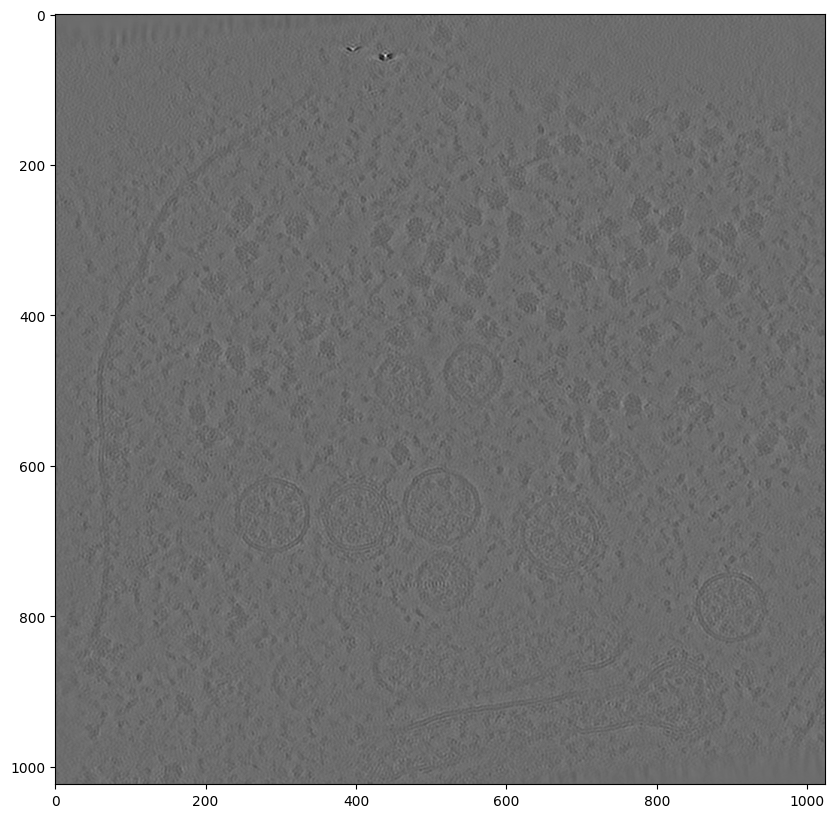

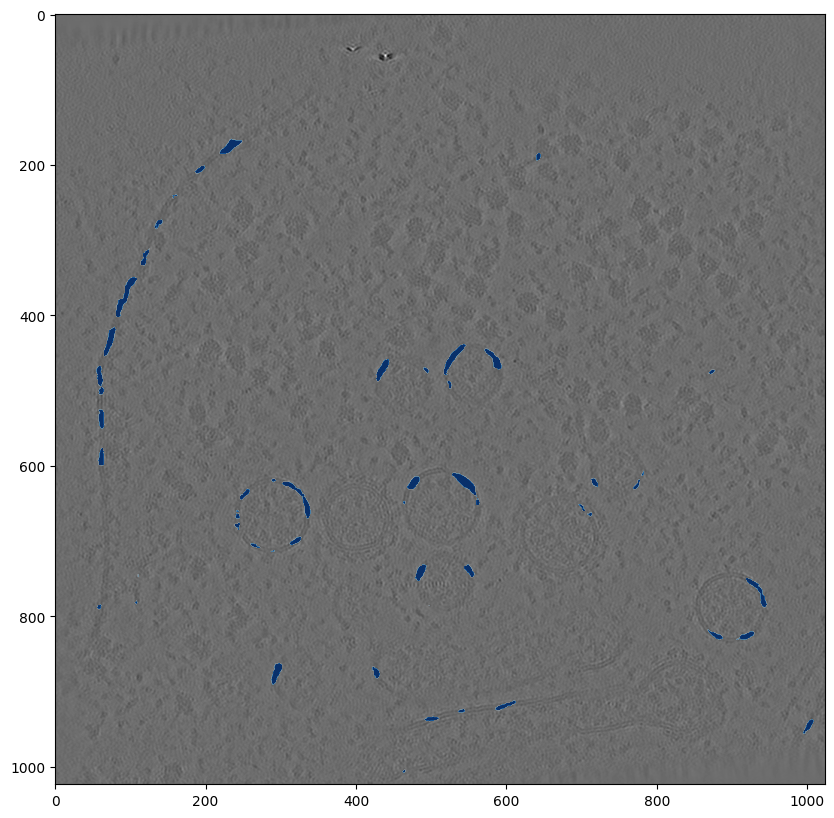

In [13]:
#@markdown ## 5.2. Visualize the prediction
#@markdown Run this cell to do visualization of particular z axis


z_axis = 256 #@param {type:"integer"}

import numpy as np
import matplotlib.pyplot as plt

# First figure: Tomogram slice
plt.figure(figsize=(10, 10))
plt.imshow(tomogram[z_axis], cmap='gray')
plt.axis('off')  # Hide axis for better visualization
plt.title(f'Tomogram Slice at Z={z_axis}')
plt.savefig(f'tomogram_slice_z{z_axis}.png', bbox_inches='tight')
plt.close()

# Second figure: Tomogram slice with Predictions overlay
plt.figure(figsize=(10, 10))
plt.imshow(tomogram[z_axis], cmap='gray')
plt.axis('off')  # Hide axis for better visualization
plt.title(f'Tomogram with Predictions Overlay at Z={z_axis}')
plt.imshow(predictions[z_axis], alpha=alphas[z_axis], cmap='Blues')
plt.savefig(f'prediction_overlay_z{z_axis}.png', bbox_inches='tight')
plt.close()